### 코랩 설정

In [ ]:
# !git clone https://github.com/yongmin21/2022_BigContest.git

In [ ]:
# %cd "/content/2022_BigContest"
# !pwd

In [ ]:
# !git lfs install
# !git lfs pull origin

In [1]:
# from google.colab import drive
# drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [55]:
# 한글폰트 사용 in colab
# %matplotlib inline  

# import matplotlib as mpl 
# import matplotlib.pyplot as plt 
# import matplotlib.font_manager as fm  

# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

# path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
# font_name = fm.FontProperties(fname=path, size=10).get_name()
# print(font_name)
# plt.rc('font', family=font_name)

# fm._rebuild()
# mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


### 데이터 로드 & 라이브러리 불러오기

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

sns.set_style("darkgrid")
sns.set_palette("deep")

matplotlib.rcParams['font.family'] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

#dir = "/gdrive/MyDrive/data/"
dir = "../data/"

In [6]:
# meta.loc['loanapply_insert_time', 'level'] = 'time'
# meta.loc['insert_time', 'level'] = 'time'
# meta.loc['is_applied', 'role'] = 'target'

# meta.to_pickle(dir + 'meta.pkl')
# meta.to_csv(dir + 'meta.csv')

In [3]:
loan_result = pd.read_parquet(dir + 'loan_result.parquet')
user_spec = pd.read_parquet(dir + "user_spec.parquet")
meta = pd.read_pickle(dir + 'meta.pkl')

data = loan_result.merge(user_spec, how='inner', on='application_id')

del loan_result, user_spec

In [4]:
data.head()

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
0,1748340,2022-06-07 13:05:41,7,191,42000000.000,13.600,NaN,430982,1996.000,1.000,...,EARNEDINCOME,20220200.000,정규직,자가,25000000.000,대환대출,0.000,0.000,2.000,15000000.000
1,1748340,2022-06-07 13:05:41,25,169,24000000.000,17.900,NaN,430982,1996.000,1.000,...,EARNEDINCOME,20220200.000,정규직,자가,25000000.000,대환대출,0.000,0.000,2.000,15000000.000
2,1748340,2022-06-07 13:05:41,2,7,24000000.000,18.500,NaN,430982,1996.000,1.000,...,EARNEDINCOME,20220200.000,정규직,자가,25000000.000,대환대출,0.000,0.000,2.000,15000000.000
3,1748340,2022-06-07 13:05:41,4,268,29000000.000,10.800,NaN,430982,1996.000,1.000,...,EARNEDINCOME,20220200.000,정규직,자가,25000000.000,대환대출,0.000,0.000,2.000,15000000.000
4,1748340,2022-06-07 13:05:41,11,118,5000000.000,16.400,NaN,430982,1996.000,1.000,...,EARNEDINCOME,20220200.000,정규직,자가,25000000.000,대환대출,0.000,0.000,2.000,15000000.000


**<가설>**
1.~~대출 승인은 대출 상환 능력이 높은 사람에게 쉽게 해줄 것이다.~~  
-> 대출 승인 여부보다 각 유저별로 대출 상품 여부가 다를 것이기 때문에 유저 군집별 대출 상품 번호를 찾아보자
~~(신용점수가 가장 영향이 높을 것이고, 정규직, 연봉, 주택소유형태 등에 영향을 많이 받을 것이다.)~~   
2. ~~1번과 마찬가지로 개인회생경험이나 기존 대출 금액이 있는 사람은 대출이 힘들 것이다.~~

### Check Missing Value

In [5]:
def get_nan_table(df, index):
    nan_df = (pd.DataFrame(
        {'total_nan': df.isnull().sum(),
         'ratio': df.isnull().sum() / df.shape[0]},
         index=index
    ))
    return nan_df

get_nan_table(data, meta.index)

,total_nan,ratio
varname,,
loanapply_insert_time,0,0.000
bank_id,0,0.000
product_id,0,0.000
loan_limit,7382,0.001
loan_rate,7382,0.001
is_applied,3257239,0.241
application_id,0,0.000
user_id,0,0.000
birth_year,128096,0.009


* 개인회생여부관련, 기대출관련 피처의 결측값이 가장 많았고, 그 외에 변수들은 조금씩 있다.  
(결측값은 나중에 처리)

# 변수 변환
### 1. purpose 카테고리 수정
* Purpuse feature에는 영어로 되어있는 라벨과 한글로 되어있는 라벨이 혼재되어 있는데, 이를 한글로 되어있는 라벨로 결합시켜야 함.

In [5]:
data['purpose'].unique()

['대환대출', '생활비', '투자', '기타', '전월세보증금', ..., 'ETC', 'BUYHOUSE', 'HOUSEDEPOSIT', 'BUYCAR', 'INVEST']
Length: 16
Categories (16, object): ['BUSINESS', 'BUYCAR', 'BUYHOUSE', 'ETC', ..., '자동차구입', '전월세보증금', '주택구입', '투자']

In [6]:
data['purpose'].replace({'BUSINESS': '사업자금', 'BUYCAR': '자동차구입', 'BUYHOUSE': '주택구입', 'LIVING': '생활비',
                         'INVEST': '투자', 'HOUSEDEPOSIT': '전월세보증금', 'SWITCHLOAN': '대환대출', 'ETC': '기타'},
                        inplace=True)
print(data['purpose'].unique())

['대환대출', '생활비', '투자', '기타', '전월세보증금', '사업자금', '주택구입', '자동차구입']
Categories (8, object): ['기타', '대환대출', '사업자금', '생활비', '자동차구입', '전월세보증금', '주택구입', '투자']


### 2. birth_year, company_enter_month 수정
* 각각 나이, 근속연수로 변경

In [7]:
data['birth_year'] = 2022 - data['birth_year'] # 만 나이
data['company_enter_month'] = data['company_enter_month'].astype(str).apply(lambda x: x[:4]).astype(float)
data['company_enter_month'] = 2022 - data['company_enter_month']

### 3. 수치형 변수에 log 변환

In [40]:
data[['loan_limit', 'yearly_income', 'desired_amount', 'existing_loan_cnt', 'existing_loan_amt']] = np.log1p(data[['loan_limit', 'yearly_income', 'desired_amount', 'existing_loan_cnt', 'existing_loan_amt']])

* 나이 또는 근속연수가 이상하게 높은 값들은 입사하기까지의 기간 최빈값을 빼줘보자

In [31]:
(data[data['birth_year'] <= data['company_enter_month']]['company_enter_month'] - 27).describe()

count   1433.000
mean      19.499
std       28.733
min       -6.000
25%        1.000
50%        7.000
75%       25.000
max       95.000
Name: company_enter_month, dtype: float64

In [26]:
(data['birth_year'] - data['company_enter_month']).mode()

0   27.000
dtype: float32

# train, test 분리
* 3 ~ 5월 데이터 : train
* 6월 데이터 : test

In [7]:
#data.to_parquet(dir + "data_2022_09_18.parquet")
data = pd.read_parquet(dir + 'data_2022_09_18.parquet')
meta = pd.read_pickle(dir + 'meta.pkl')

In [8]:
train = data[data['loanapply_insert_time'] < '2022-06-01']
test = data[data['loanapply_insert_time'] >= '2022-06-01']

# Categorical Variables
### 0. target 분포 확인

<AxesSubplot:xlabel='is_applied', ylabel='count'>

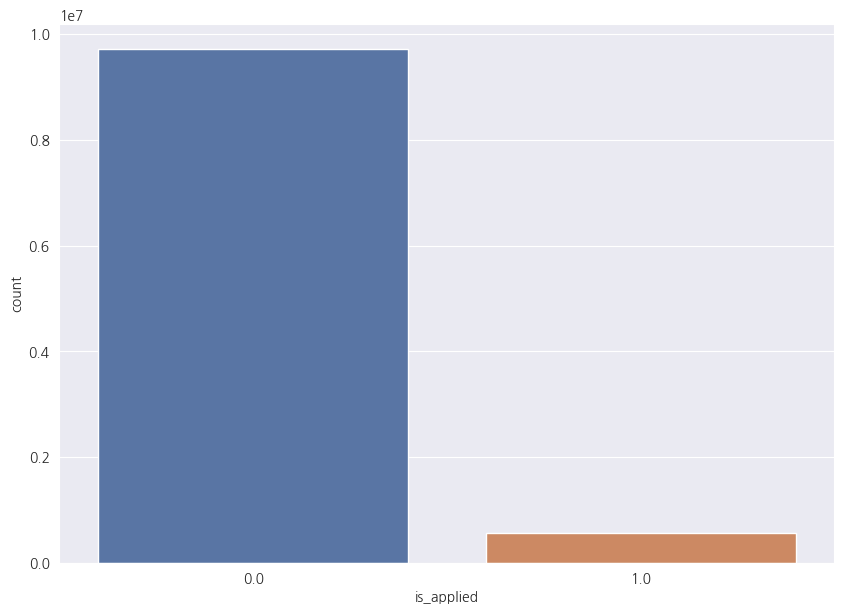

In [11]:
plt.figure(figsize=(10,7))
sns.countplot(x='is_applied', data=data)

* 아주 심하게 unbalanced된 데이터이다.
* UnderSampling 또는 OverSampling 기법을 통해 적절히 분포를 조정해줘야 할 것이다.
* 모델링 단계에서 stratified k-fold, 교차검증을 통해 충분히 오버피팅을 방지해줄 필요가 있다.
* 검증 metric으로 F1-score, ROC-AUC curve 등을 활용하는 것이 좋다.

In [12]:
data['is_applied'].value_counts() / len(data['is_applied'])

0.000   0.718
1.000   0.041
Name: is_applied, dtype: float64

### 각 변수별 1값의 비율 확인

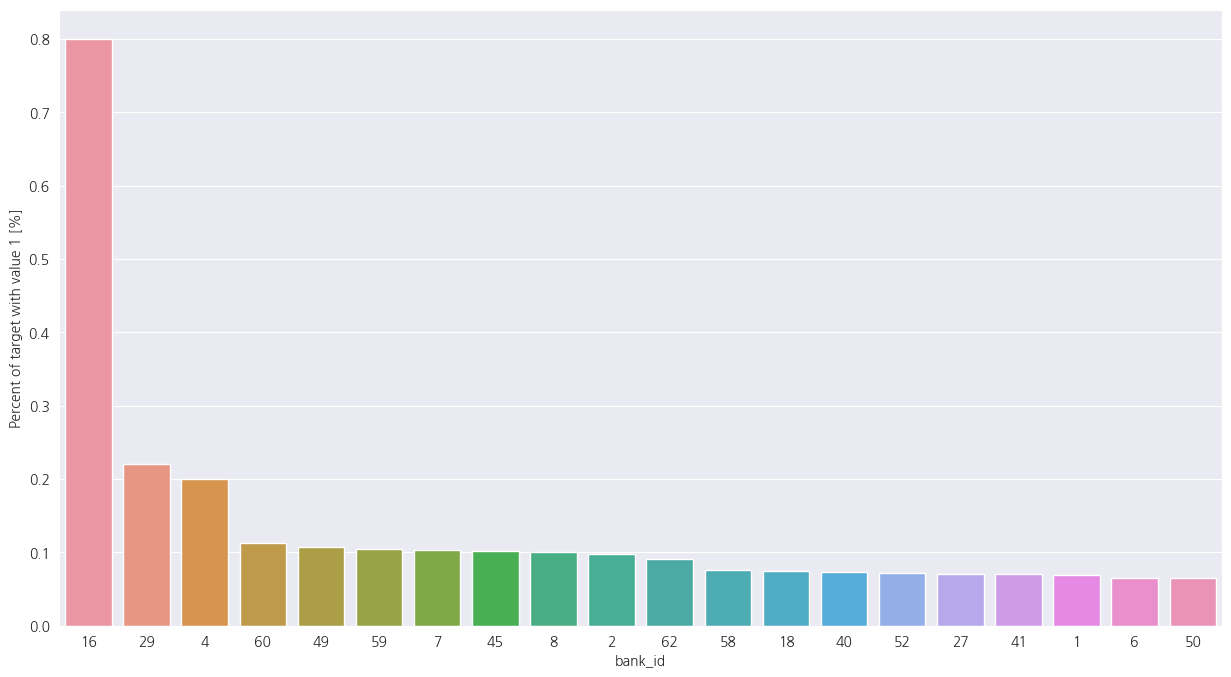

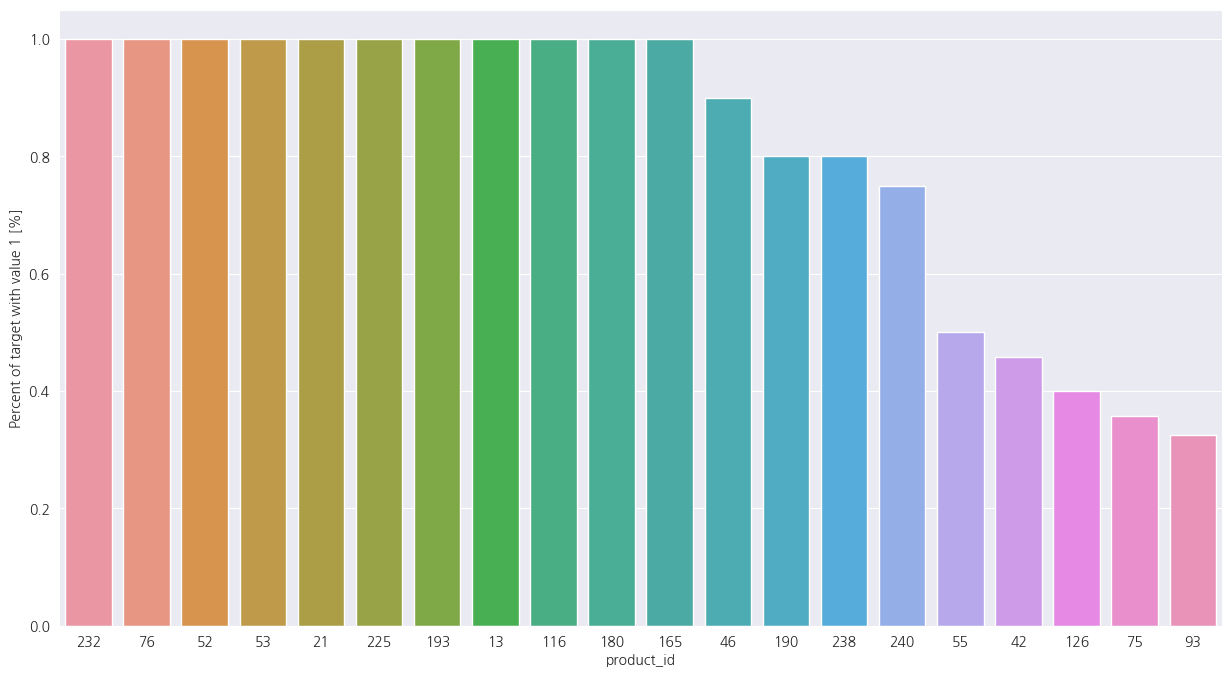

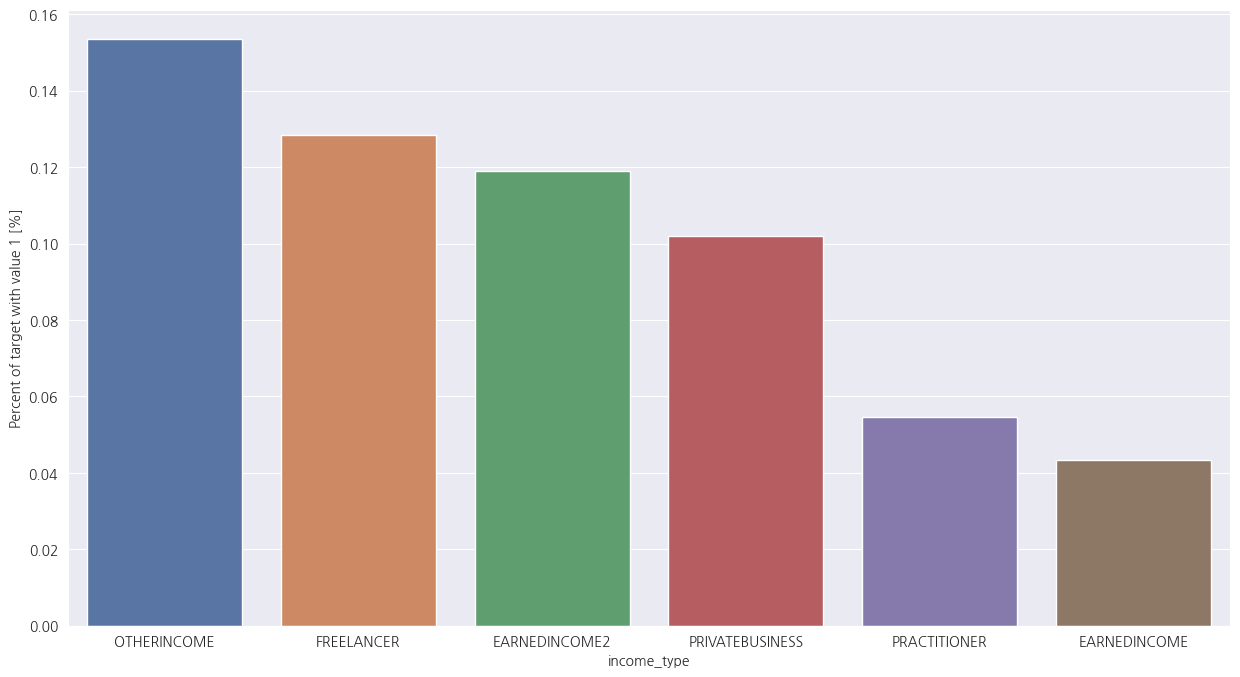

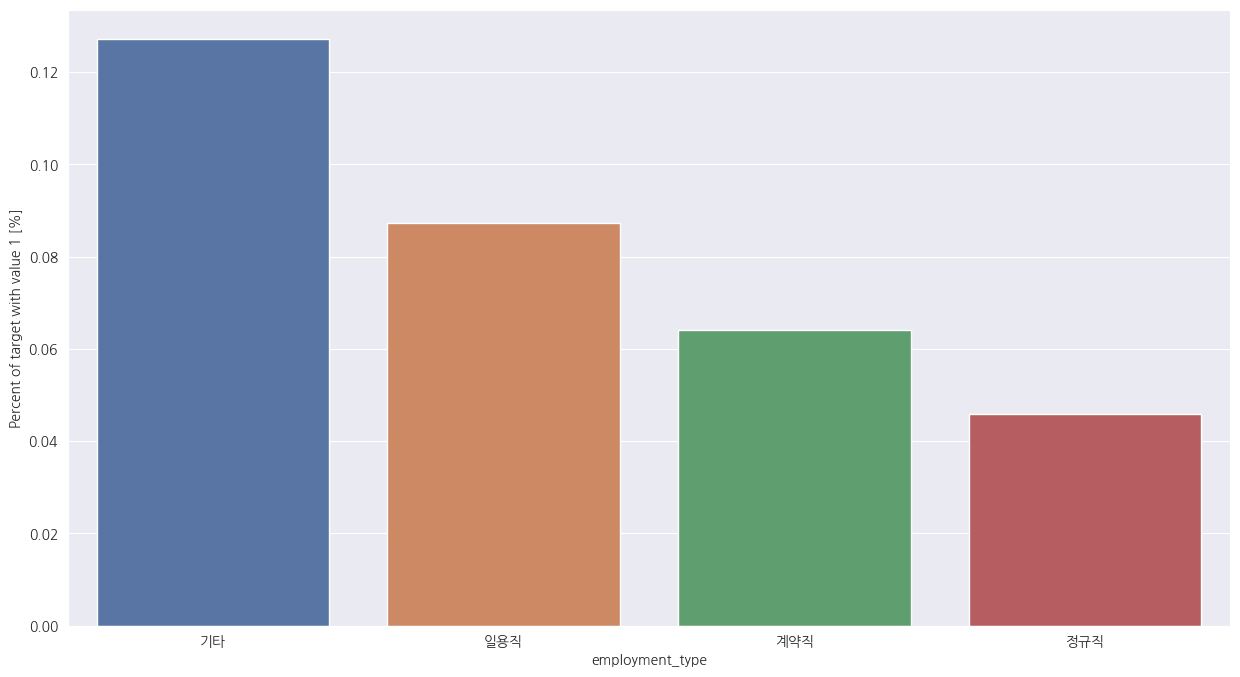

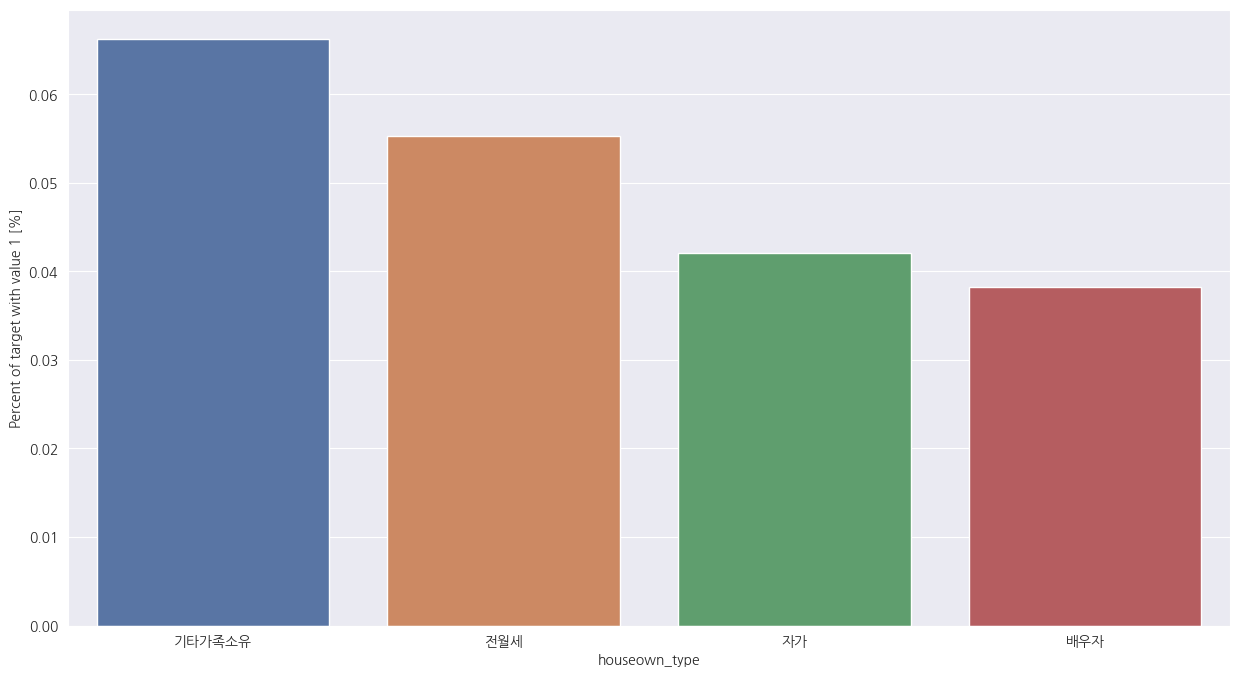

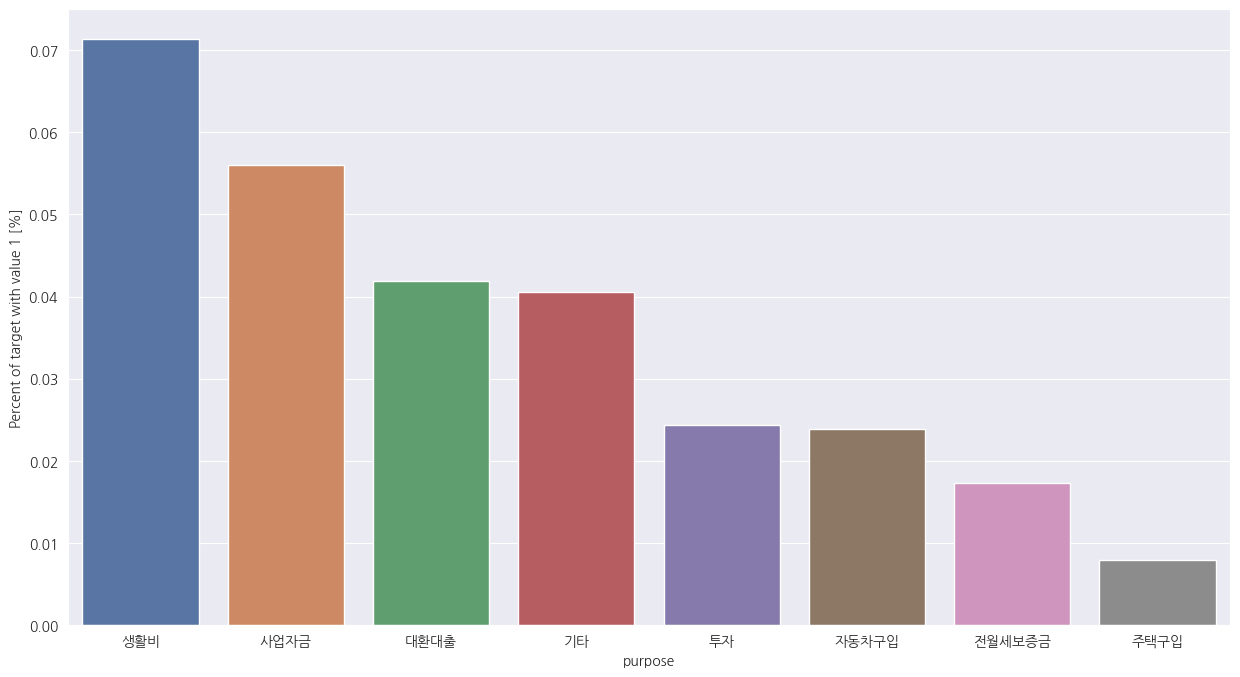

In [22]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
#v = ['bank_id', 'product_id', 'income_type', 'employment_type', 'houseown_type', 'purpose']

for f in v:
    fig, ax = plt.subplots(figsize=(15,8))

    cat_perc = (train[[f, 'is_applied']]
                .groupby([f], as_index=False)
                .mean()
                .sort_values(by='is_applied', ascending=False))

    if len(cat_perc.index) > 20:
        cat_perc = cat_perc[:20] # use top 20

    sns.barplot(data=cat_perc, x=f, y='is_applied', order=cat_perc[f], ax=ax)
    plt.ylabel('Percent of target with value 1 [%]')
    plt.xlabel(f)
    #plt.tick_params(axis='both', whichi='major', labelsize=12)
    plt.show();


* 생각했던 것과는 달리 실제 대출 승인 비율을 확인했을 때 income_type은 OTHERINCOME(기타소득), FREELANCER(프리랜서), EARNEDINCOME2(4대보험이 없는 직장 가입자), PRIVATEBUSINESS, PRACTITIONER, EARNEDINCOME 순으로 가장 많은 승인을 받았다. 
* 고용 형태도 기타, 일용직, 계약직, 정규직 순으로 대출 승인을 받았다.
* 주택소유 형태도 기타가족소유, 전월세, 자가, 배우자 순으로 대출 승인을 받았다.
* purpose는 생활비, 사업자금, 대환대출 순으로 대출 승인을 받았다.  
**대출은 천천히 오래 갚아나갈 수 있는 사람을 오히려 선호하는 것처럼 보인다.**

In [24]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame()
data_mapped = {}

v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    if "id" in f:
        data_encoded[f] = train[f]
        data_mapped[f] = train[f].unique()
        continue
    data_encoded[f] = label.fit_transform(train[f])
    data_mapped[f] = dict(zip(label.classes_, label.transform(label.classes_)))
data_encoded['is_applied'] = train['is_applied']


<Figure size 432x288 with 0 Axes>

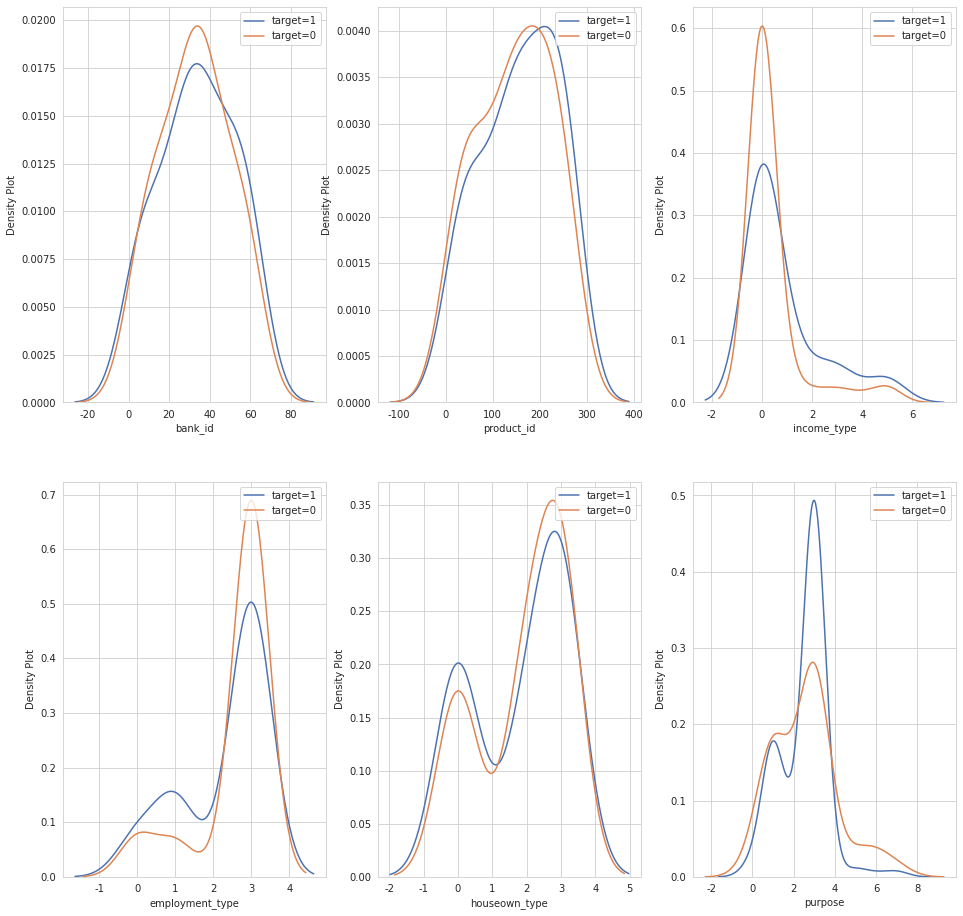

In [59]:
d1 = data_encoded.loc[data_encoded['is_applied'] != 0]
d0 = data_encoded.loc[data_encoded['is_applied'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2, 3, figsize=(16,16))

i=0
for f in v:
    i += 1
    plt.subplot(2, 3, i)
    sns.kdeplot(d1[f], bw=0.5, label='target=1')
    sns.kdeplot(d0[f], bw=0.5, label="target=0")
    plt.ylabel("Density Plot")
    plt.xlabel(f)
    plt.legend(loc='upper right')
plt.show();

* 분포가 눈에 띄게 차이가 나는 변수는 없다.
* 은행은 20 ~ 40번대 사이, 대출 상품은 100 ~ 300번대 사이의 값이 가장 많은 분포를 이루는 것을 알 수 있다.
* 대부분의 범주형 변수들은 분포가 크게 다르지 않은 것을 볼 수 있다.
* 범주형 변수로 타겟에 유의미한 정보를 줄 수 없어 보인다.

**정리하면**, target 데이터는 매우 심한 imbalanced 데이터이며, 샘플링을 통해 처리해야 할 것이다.  
~~또 가설과 달리 대출 승인은 오히려 대출을 잘 갚을 수 있는 사람에게 주지 않는다는 것을 알 수 있었다.~~


In [1]:
import joblib

xgb_model = joblib.load(open("../models/xgb_0.bin", "rb"))

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


<BarContainer object of 19 artists>

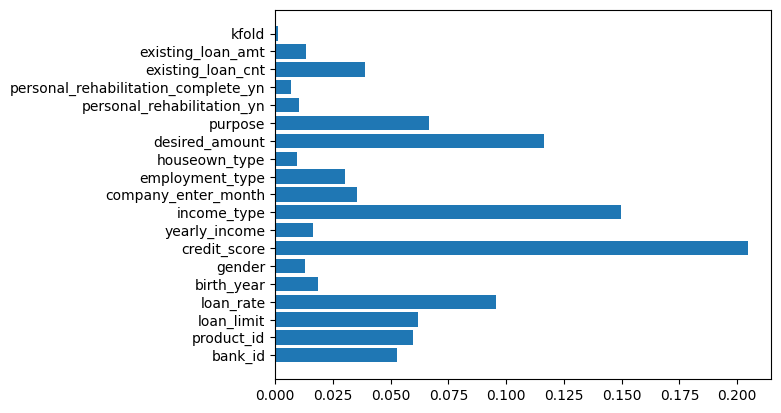

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

features = pd.read_parquet("../data/train_folds.parquet").drop(['is_applied'], axis=1).columns
plt.barh(features, xgb_model.feature_importances_)

### 카테고리 파생변수 생성

In [10]:
# user_id 대신
data = pd.read_parquet("../data/data_2022_09_19.parquet")

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
13301,2157865,2022-05-09 08:44:59,54,235,16.811243,16.5,1.0,346970,52.0,1.0,...,0.0,9.0,3.0,2.0,16.118095,3.0,0.0,NaN,2.564949,18.903107
13302,576643,2022-05-09 10:54:53,54,235,16.213406,16.5,0.0,545882,45.0,1.0,...,0.0,3.0,3.0,3.0,16.811243,3.0,0.0,NaN,2.079442,18.478951
13303,576643,2022-05-09 10:54:53,11,118,14.914124,20.0,0.0,545882,45.0,1.0,...,0.0,3.0,3.0,3.0,16.811243,3.0,0.0,NaN,2.079442,18.478951
13304,2136706,2022-05-09 10:41:06,42,216,16.118095,13.5,0.0,558819,39.0,1.0,...,0.0,10.0,3.0,3.0,18.197536,1.0,0.0,NaN,1.098612,17.875954
13305,2136706,2022-05-09 10:41:07,25,169,16.906553,15.9,0.0,558819,39.0,1.0,...,0.0,10.0,3.0,3.0,18.197536,1.0,0.0,NaN,1.098612,17.875954


### Category Encoding

In [9]:
from sklearn.preprocessing import OrdinalEncoder

cats_features = ['income_type', 'company_enter_month', 'employment_type', 'houseown_type', 'purpose']

for f in cats_features:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                        unknown_value=-1)

    train[f] = oe.fit_transform(np.array(train[f]).reshape(-1,1))
    test[f] = oe.transform(np.array(test[f]).reshape(-1,1))

# Interval (Numeric) Variables

In [43]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
data[v].describe()

,loan_limit,loan_rate,birth_year,credit_score,yearly_income,company_enter_month,desired_amount,existing_loan_cnt,existing_loan_amt
count,13519868.000,13519868.000,13399154.000,12017974.000,13527244.000,13126913.000,13527250.000,10841541.000,9637087.000
mean,16.556,12.752,39.200,752.266,17.398,4.312,16.951,1.370,17.524
std,1.028,3.843,9.645,127.641,1.207,5.458,1.345,0.545,1.978
min,0.000,1.500,19.000,60.000,0.000,0.000,0.000,0.693,0.000
25%,16.013,9.600,31.000,650.000,17.183,1.000,16.118,0.693,17.034
50%,16.706,13.200,38.000,730.000,17.399,2.000,17.148,1.386,17.707
75%,17.312,15.600,46.000,860.000,17.728,5.000,17.728,1.792,18.380
max,26.165,20.000,92.000,1000.000,23.026,122.000,23.026,5.438,22.740


* anomalies가 일부 피처에 존재하는 것 같다.
* 각 피처별 히스토그램을 그려 아노말리의 존재를 좀 더 찾아보자.

<Figure size 640x480 with 0 Axes>

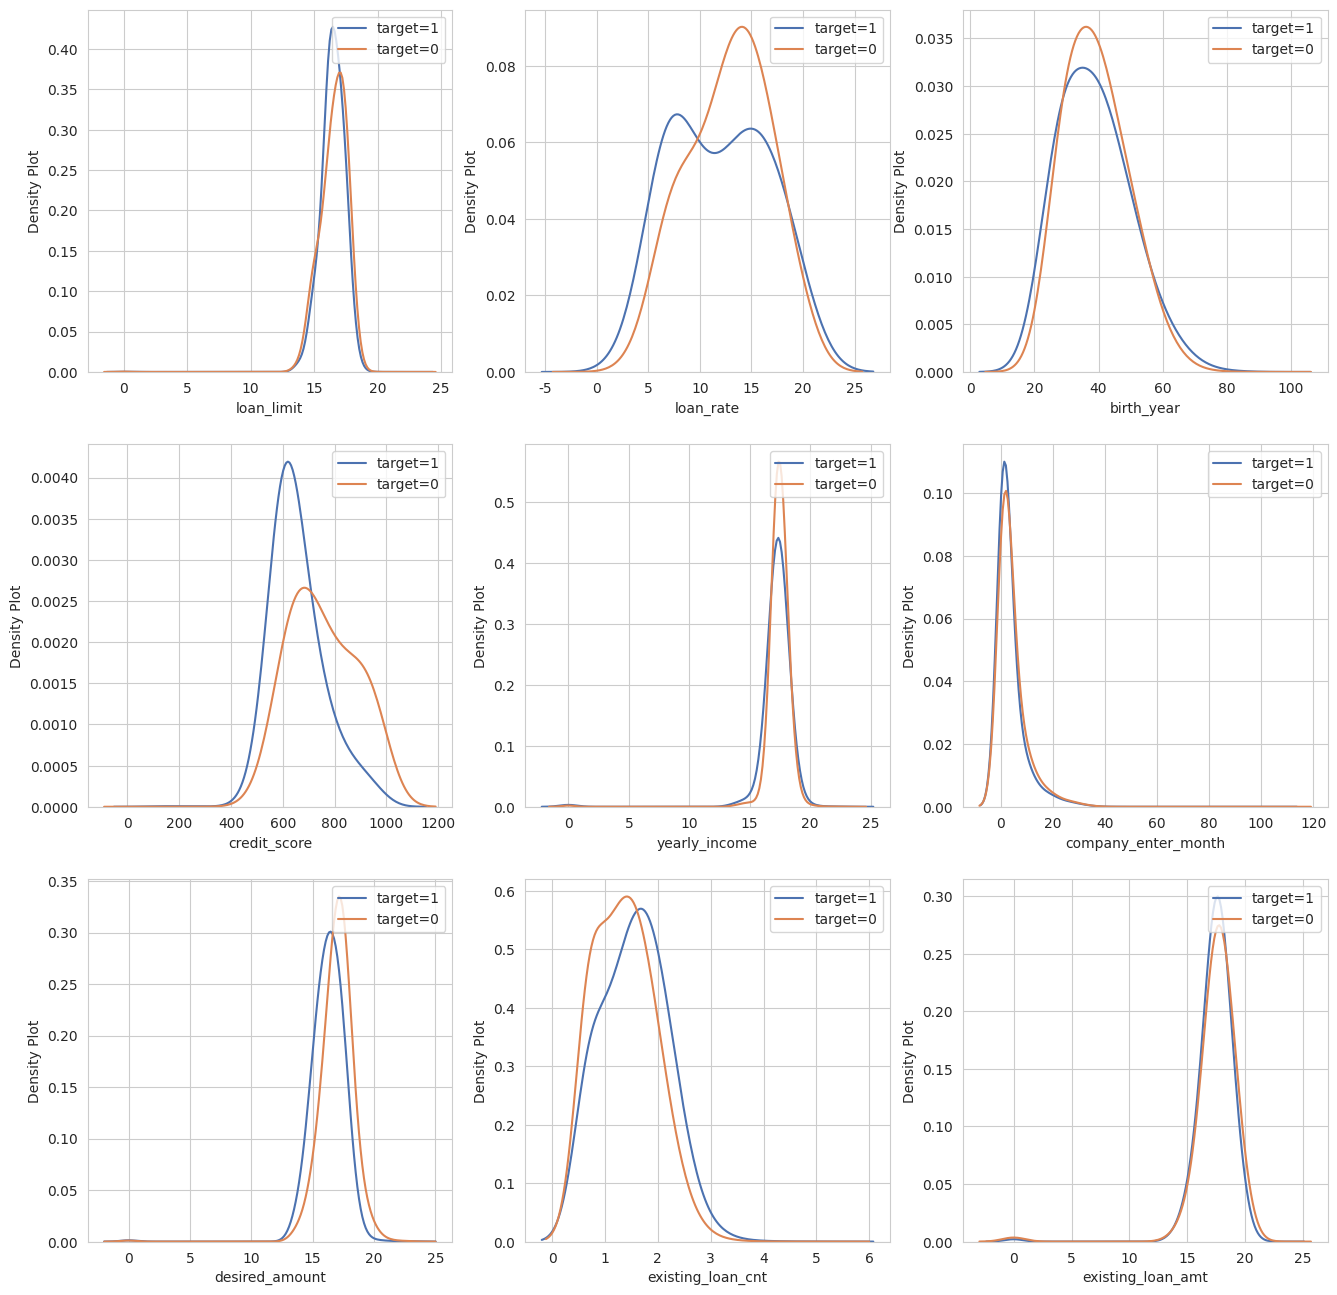

In [44]:
v = meta[((meta.level == 'interval') & (meta.keep)) | (meta.role == 'target')].index
int_data = train[v]

d1 = int_data.loc[int_data['is_applied'] != 0]
d0 = int_data.loc[int_data['is_applied'] == 0]

del int_data

sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(3, 3, figsize=(16,16))

i=0
for f in v:
    if f =='is_applied':
        continue
    
    i += 1
    plt.subplot(3, 3, i)
    sns.kdeplot(d1[f], bw=0.5, label='target=1')
    sns.kdeplot(d0[f], bw=0.5, label="target=0")
    plt.ylabel("Density Plot")
    plt.xlabel(f)
    plt.legend(loc='upper right')
plt.show();

* loan_limit, yearly_income, company_enter_month, disired_amount, existing_loan_cnt, existing_loan_amt 피처에는 확실히 anomalies가 존재하는 것으로 보인다.
* ~~anomalies를 log를 취해 제거해주도록 하자.~~

In [39]:
# train[['loan_limit', 'yearly_income', 'desired_amount', 'existing_loan_cnt', 'existing_loan_amt']] = np.log1p(train[['loan_limit', 'yearly_income', 'desired_amount', 'existing_loan_cnt', 'existing_loan_amt']])
# test[['loan_limit', 'yearly_income', 'desired_amount', 'existing_loan_cnt', 'existing_loan_amt']] = np.log1p(test[['loan_limit', 'yearly_income', 'desired_amount', 'existing_loan_cnt', 'existing_loan_amt']])

<Figure size 640x480 with 0 Axes>

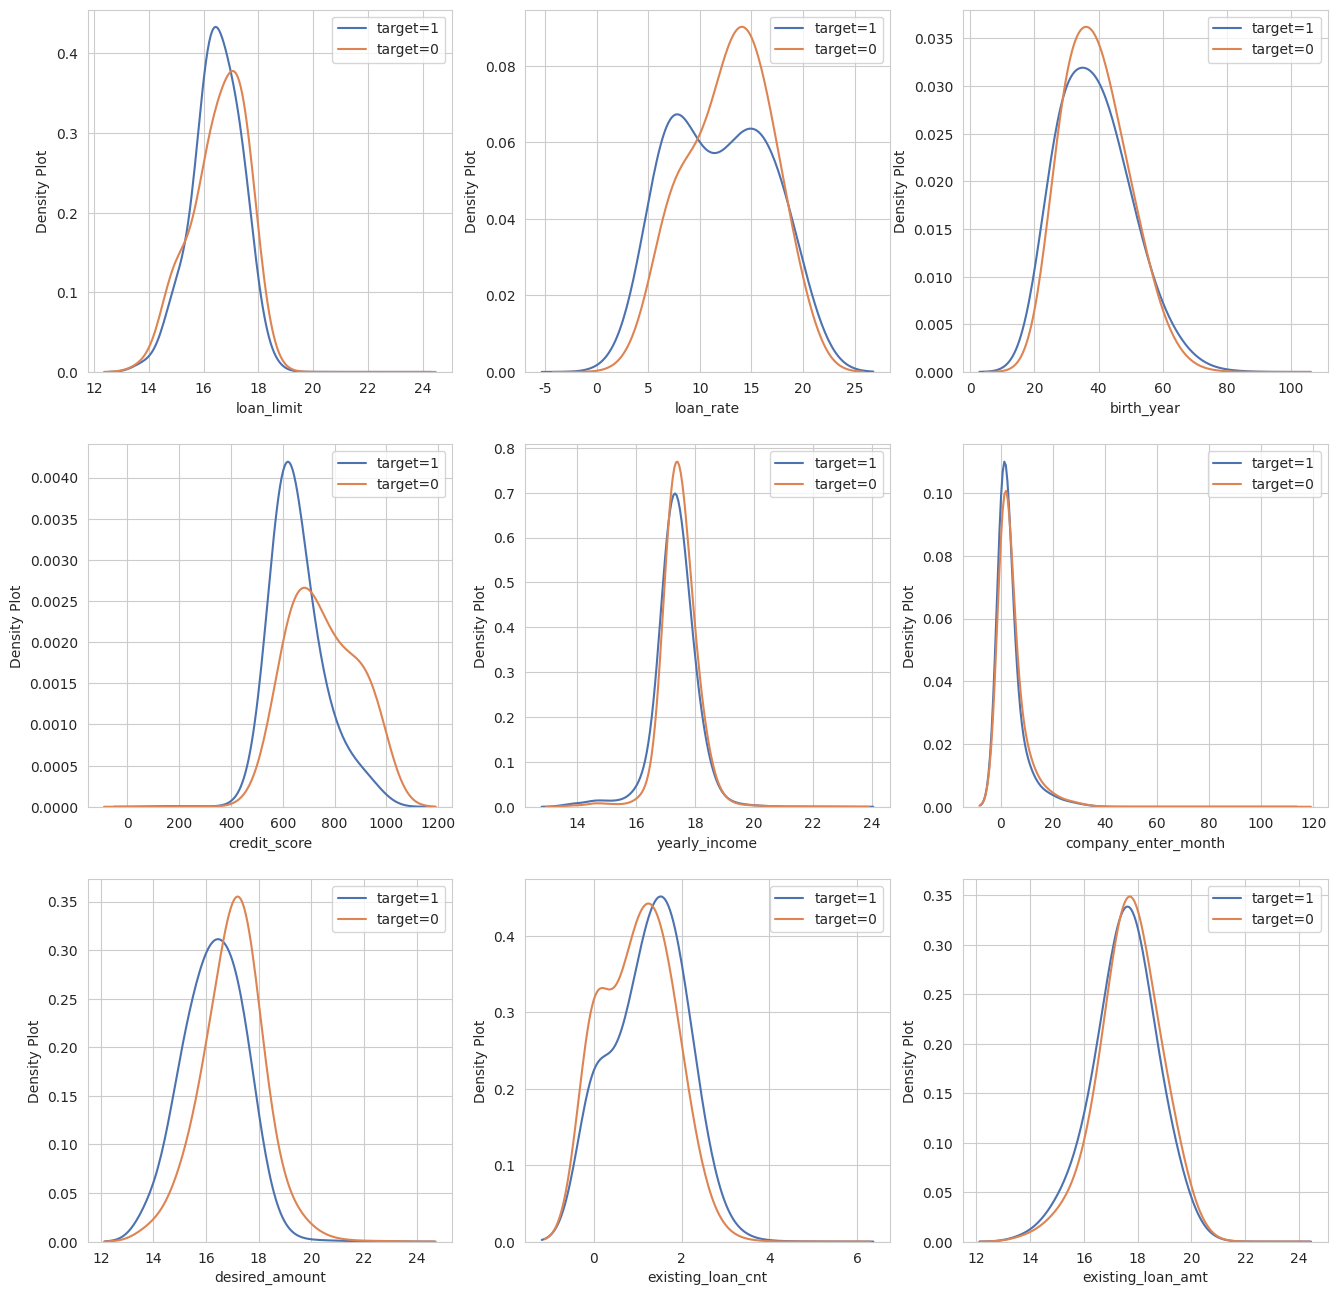

In [14]:
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(3, 3, figsize=(16,16))

i=0
for f in v:
    if f =='is_applied':
        continue
    
    if f in ['loan_limit', 'yearly_income', 'desired_amount', 'existing_loan_cnt', 'existing_loan_amt']:
        d1[f] = np.log(d1[f])
        d0[f] = np.log(d0[f])
        
    i += 1
    plt.subplot(3, 3, i)
    sns.kdeplot(d1[f], bw=0.5, label='target=1')
    sns.kdeplot(d0[f], bw=0.5, label="target=0")
    plt.ylabel("Density Plot")
    plt.xlabel(f)
    plt.legend(loc='upper right')
plt.show();

* 로그를 취하니 분포가 다른 변수들이 보이기 시작한다.
* 근속연수에서 이상치가 존재하는 것 처럼 보인다.

In [79]:
# def tukey_outliers(df):
#     Q1, Q3 = np.percentile(df.dropna(), [25, 75])
#     IQR = Q3 - Q1

#     lower_bound = Q1 - (IQR * 1.5)
#     upper_bound = Q3 + (IQR * 1.5)

#     outliers = df[(df > upper_bound) | (df < lower_bound)]
#     return outliers

# company_outliers = tukey_outliers(train['company_enter_month'])

In [9]:
# 자기 나이보다 근속연수가 더 많은 사람들이 있었다. 이 값들을 같은 나이를 가진 사람들의 근속연수로 바꿔주자.
outliers_list = train[train['company_enter_month'] > train['birth_year']].birth_year.unique()

In [126]:
train[train['company_enter_month'] > train['birth_year']].groupby('birth_year')['company_enter_month'].describe()

,count,mean,std,min,25%,50%,75%,max
birth_year,,,,,,,,
20.000,4.000,22.000,0.000,22.000,22.000,22.000,22.000,22.000
22.000,15.000,40.000,0.000,40.000,40.000,40.000,40.000,40.000
26.000,35.000,32.714,1.178,28.000,33.000,33.000,33.000,33.000
27.000,8.000,32.000,0.000,32.000,32.000,32.000,32.000,32.000
28.000,14.000,47.000,0.000,47.000,47.000,47.000,47.000,47.000
31.000,9.000,32.000,0.000,32.000,32.000,32.000,32.000,32.000
35.000,31.000,53.000,0.000,53.000,53.000,53.000,53.000,53.000
41.000,5.000,45.000,0.000,45.000,45.000,45.000,45.000,45.000
42.000,3.000,43.000,0.000,43.000,43.000,43.000,43.000,43.000


### 상관관계 파악

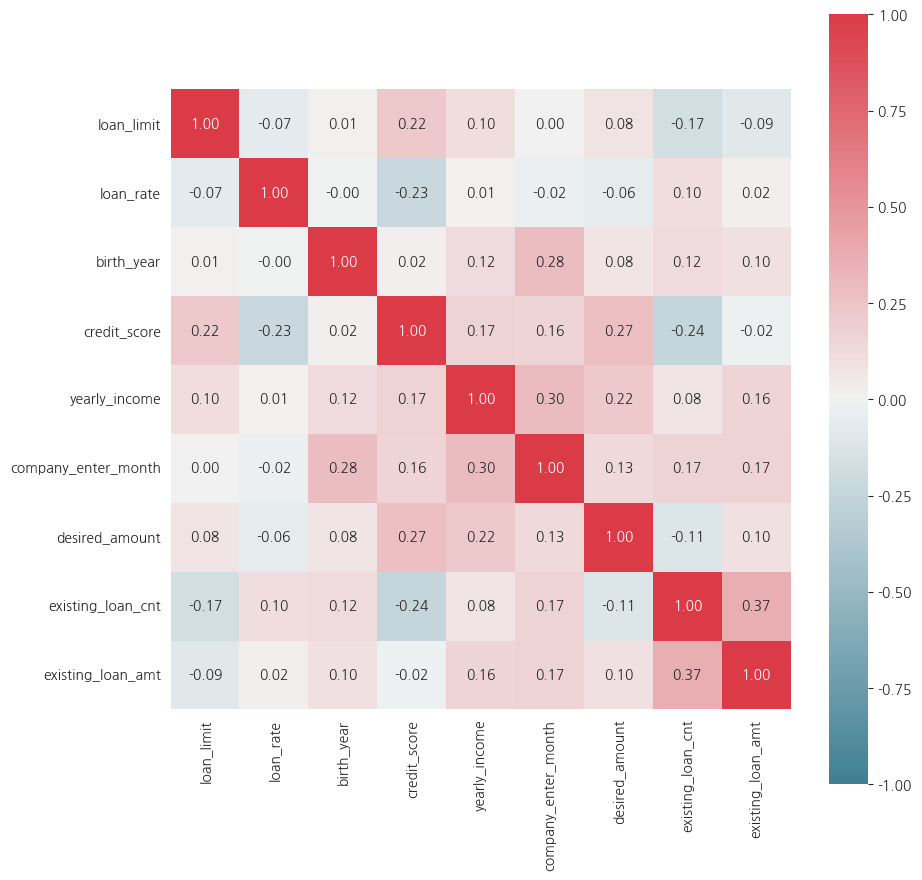

In [5]:
v = meta[(meta.level == 'interval') & (meta.keep)].index

corr_df = train[v].dropna().corr()

fig, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_df, cmap=cmap, vmax=1.0, vmin=-1., center=0, fmt='.2f',
            square=True, annot=True)
plt.show();

In [6]:
v = meta[meta.keep].index
correlations = data[v].corr()['is_applied'].sort_values()
print('most Positive Correlations: \n', correlations.tail(5)[::-1])
print('\nMost Negative Correlations: \n', correlations.head(5))

most Positive Correlations: 
 is_applied                   1.000
existing_loan_cnt            0.080
product_id                   0.035
personal_rehabilitation_yn   0.017
bank_id                      0.016
Name: is_applied, dtype: float64

Most Negative Correlations: 
 credit_score          -0.177
desired_amount        -0.124
loan_rate             -0.052
yearly_income         -0.039
company_enter_month   -0.027
Name: is_applied, dtype: float64


* credit_score는 loan_limit, existing_loan_amt와 약한 양의 상관관계, loan_rate, existing_loan_cnt, company_enter_month 와 약한 음의 상관관계가 있다.  
    -> 즉, 신용점수가 높을수록 대출한도가 높아지고, 금리도 낮아진다.  
    
* 태어난 년도는 company_enter_month와 약한 양의 상관관계가 있고, existing_loan_amount와 약한 음의 상관관계가 있다.  
    -> 당연히도, 오래 살 수록 입사년도도 훨씬 빠를 것이고, 기대출금액도 갚을 수 있는 기간이 많으므로 작아질 것이다.

target 변수와의 상관관계를 비교해봤을 때, existing_loan_cnt는 매우 약한 양의 상관관계가 있고, credit_score는 매우 약한 음의 상관관계가 있다.

# Binary Variables

In [25]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,is_applied,gender,personal_rehabilitation_yn,personal_rehabilitation_complete_yn
count,10270011.000,10178385.000,4396782.000,1037779.000
mean,0.055,0.694,0.005,0.004
std,0.227,0.461,0.072,0.063
min,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000
50%,0.000,1.000,0.000,0.000
75%,0.000,1.000,0.000,0.000
max,1.000,1.000,1.000,1.000


In [26]:
for f in v:
    if f == "is_applied":
        continue
    
    ratio_tab = (data[[f, 'is_applied']]
                 .groupby([f], as_index=False)
                 .mean())
    print(ratio_tab)
    print("=" * 80)

   gender  is_applied
0   0.000       0.059
1   1.000       0.053
   personal_rehabilitation_yn  is_applied
0                       0.000       0.057
1                       1.000       0.112
   personal_rehabilitation_complete_yn  is_applied
0                                0.000       0.056
1                                1.000       0.076


In [12]:
data_all = pd.concat([train, test], axis=0)
data_all.to_parquet(dir + "data_2022_09_19.parquet")

# 언더샘플링

In [1]:
import pandas as pd
dir = "../data/"
train = pd.read_parquet(dir + "train_impute.parquet")
train.head()

,bank_id,product_id,loan_limit,loan_rate,is_applied,birth_year,gender,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
13301,54,235,16.811243,16.5,1.0,52.0,1.0,540.0,17.281246,0.0,9.0,3.0,2.0,16.118095,3.0,0.0,-1.0,2.564949,18.903107
13302,54,235,16.213406,16.5,0.0,45.0,1.0,580.0,18.092176,0.0,3.0,3.0,3.0,16.811243,3.0,0.0,-1.0,2.079442,18.478951
13303,11,118,14.914124,20.0,0.0,45.0,1.0,580.0,18.092176,0.0,3.0,3.0,3.0,16.811243,3.0,0.0,-1.0,2.079442,18.478951
13304,42,216,16.118095,13.5,0.0,39.0,1.0,740.0,17.479073,0.0,10.0,3.0,3.0,18.197536,1.0,0.0,-1.0,1.098612,17.875954
13305,25,169,16.906553,15.9,0.0,39.0,1.0,740.0,17.479073,0.0,10.0,3.0,3.0,18.197536,1.0,0.0,-1.0,1.098612,17.875954


In [3]:
from imblearn.over_sampling import SMOTE
X_train = train.drop(['is_applied'], axis=1)
y_train = train.is_applied.values

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

: 

: 

In [81]:
from sklearn.utils import shuffle

desired_apriori=0.25

# Get the indices per target value
idx_0 = train[train.is_applied == 0].index
idx_1 = train[train.is_applied == 1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
undersampled_data = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.17312711290542682
Number of records with target=0 after undersampling: 1681008


In [82]:
undersampled_data.describe()

,application_id,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,credit_score,yearly_income,company_enter_month,desired_amount,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
count,2241344.000,2241344.000,2241344.000,2235719.000,2235719.000,2241344.000,2241344.000,2221678.000,2221678.000,1982754.000,2241344.000,2150251.000,2241344.000,2241344.000,2241344.000,2241344.000,2241344.000
mean,1083547.700,33.054,148.482,22043934.000,12.590,0.250,440256.030,39.132,0.689,730.528,47197988.000,4.197,46158308.000,0.003,-0.898,3.102,58520880.000
std,625795.310,17.410,78.627,25400950.000,4.045,0.433,253881.859,9.892,0.463,128.161,131872456.000,5.387,220821168.000,0.052,0.304,3.420,88497400.000
min,1.000,1.000,1.000,0.000,1.500,0.000,9.000,19.000,0.000,100.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000
25%,541947.750,20.000,75.000,9000000.000,9.200,0.000,221047.000,31.000,0.000,630.000,28000000.000,1.000,10000000.000,0.000,-1.000,1.000,8000000.000
50%,1083676.000,34.000,150.000,17000000.000,13.000,0.000,440596.000,38.000,1.000,710.000,36000000.000,2.000,20000000.000,0.000,-1.000,2.000,29000000.000
75%,1625485.000,47.000,221.000,32000000.000,15.800,0.250,660726.000,46.000,1.000,830.000,50000000.000,5.000,46000000.000,0.000,-1.000,4.000,69000000.000
max,2167826.000,64.000,270.000,10000000000.000,20.000,1.000,879697.000,90.000,1.000,1000.000,10000000000.000,111.000,10000000000.000,1.000,1.000,178.000,7512000000.000


In [83]:
train.describe()

,application_id,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,credit_score,yearly_income,company_enter_month,desired_amount,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
count,10270011.000,10270011.000,10270011.000,10264386.000,10264386.000,10270011.000,10270011.000,10178385.000,10178385.000,9026199.000,10270011.000,9966443.000,10270011.000,10270011.000,10270011.000,10270011.000,10270011.000
mean,1083174.405,32.812,146.141,22608278.000,12.766,0.055,440277.138,39.218,0.694,750.042,47919432.000,4.320,51591504.000,0.002,-0.899,2.885,59042944.000
std,625812.795,17.161,78.224,22307412.000,3.886,0.227,253861.780,9.641,0.461,127.487,131875920.000,5.428,232339920.000,0.047,0.303,3.166,89589520.000
min,1.000,1.000,1.000,0.000,1.500,0.000,9.000,19.000,0.000,100.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000
25%,541821.000,19.000,71.000,9000000.000,9.500,0.000,221242.000,32.000,0.000,650.000,29000000.000,1.000,10000000.000,0.000,-1.000,1.000,7000000.000
50%,1083355.000,34.000,150.000,18000000.000,13.200,0.000,440314.000,38.000,1.000,730.000,36000000.000,2.000,28000000.000,0.000,-1.000,2.000,29000000.000
75%,1624471.500,47.000,216.000,33000000.000,15.800,0.000,661215.000,46.000,1.000,860.000,50000000.000,5.000,50000000.000,0.000,-1.000,4.000,70000000.000
max,2167826.000,64.000,270.000,10000000000.000,20.000,1.000,879697.000,92.000,1.000,1000.000,10000000000.000,111.000,10000000000.000,1.000,1.000,178.000,7512000000.000


# 결측값 처리
* 카테고리형 변수들의 결측값은 'missing value' 라는 또 다른 카테고리로 만들어주기
* 수치형 변수들의 결측값은 iterative imputer로 채워줘보자.

In [6]:
# train의 결측값 개수 확인
get_nan_table(train, meta.index)

,total_nan,ratio
varname,,
loanapply_insert_time,0,0.000
bank_id,0,0.000
product_id,0,0.000
loan_limit,5625,0.001
loan_rate,5625,0.001
is_applied,0,0.000
application_id,0,0.000
user_id,0,0.000
birth_year,91626,0.009


In [7]:
def impute_nan(df):
    df.fillna({'personal_rehabilitation_yn': 0,
               'personal_rehabilitation_complete_yn' : -1,
               'existing_loan_cnt': 0
               }, inplace=True)

    df.loc[df['existing_loan_cnt']==0, 'existing_loan_amt'] = (df
                                                               .loc[df['existing_loan_cnt']==0, 'existing_loan_amt']
                                                               .fillna(0))

    df['existing_loan_amt'].fillna(18000000., inplace=True) 
    # 기대출금액의 결측값은 모두 기대출수가 1인 값들로부터 나왔기 때문에, 기대출수가 1인 값들의 기대출금액 중앙값으로 대치

impute_nan(train)
impute_nan(test)


In [8]:
get_nan_table(train, meta.index)

,total_nan,ratio
varname,,
loanapply_insert_time,0,0.000
bank_id,0,0.000
product_id,0,0.000
loan_limit,5625,0.001
loan_rate,5625,0.001
is_applied,0,0.000
application_id,0,0.000
user_id,0,0.000
birth_year,91626,0.009


<Figure size 640x480 with 0 Axes>

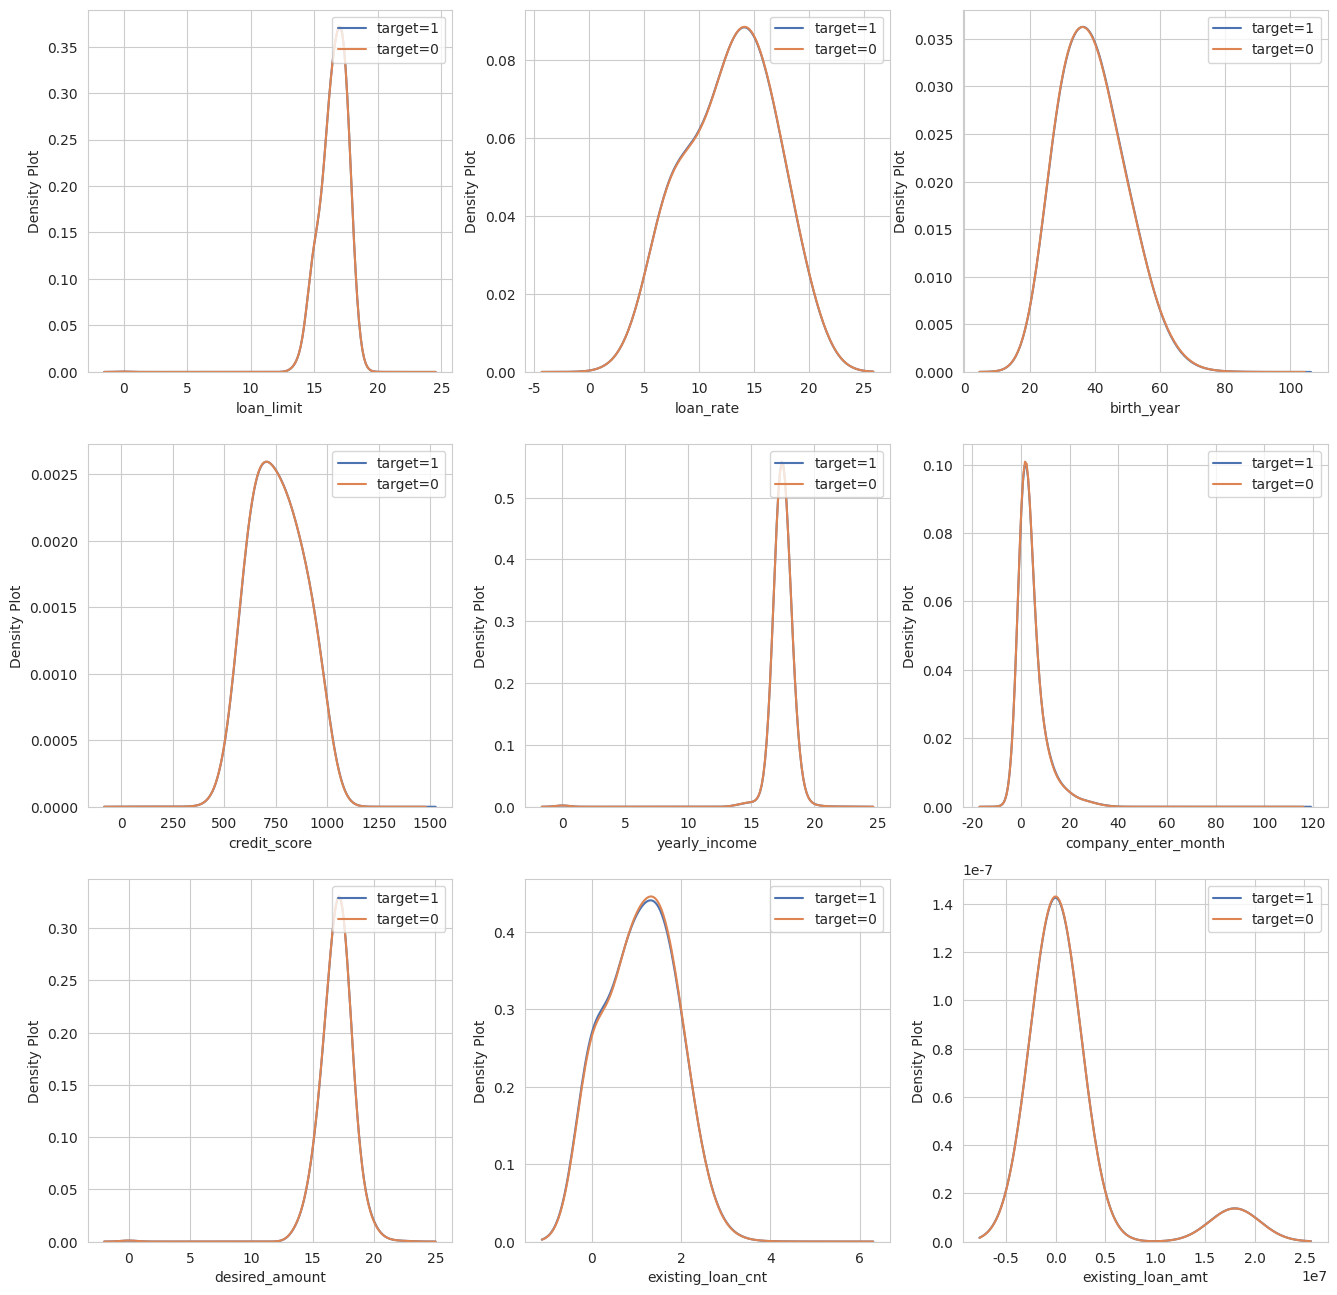

In [21]:
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(3, 3, figsize=(16,16))


v = int_v.append(pd.Index(['is_applied']))
df = pd.concat([train_int_v, train['is_applied']], axis=1)

d1 = df.loc[df['is_applied'] != 0]
d0 = df.loc[df['is_applied'] == 0]

i=0
for f in v:
    if f =='is_applied':
        continue
    
    # if f in ['loan_limit', 'yearly_income', 'desired_amount', 'existing_loan_cnt', 'existing_loan_amt']:
    #     d1[f] = np.log(d1[f])
    #     d0[f] = np.log(d0[f])
        
    i += 1
    plt.subplot(3, 3, i)
    sns.kdeplot(d1[f], bw=0.5, label='target=1')
    sns.kdeplot(d0[f], bw=0.5, label="target=0")
    plt.ylabel("Density Plot")
    plt.xlabel(f)
    plt.legend(loc='upper right')
plt.show();

In [10]:
train_imputed = train.copy()
train_imputed[int_v] = train_int_v

In [12]:
train_int_v

varname,loan_limit,loan_rate,birth_year,credit_score,yearly_income,company_enter_month,desired_amount,existing_loan_cnt,existing_loan_amt
0,16.811,16.500,52.000,540.000,17.281,9.000,16.118,2.565,18.903
1,16.213,16.500,45.000,580.000,18.092,3.000,16.811,2.079,18.479
2,14.914,20.000,45.000,580.000,18.092,3.000,16.811,2.079,18.479
3,16.118,13.500,39.000,740.000,17.479,10.000,18.198,1.099,17.876
4,16.907,15.900,39.000,740.000,17.479,10.000,18.198,1.099,17.876
...,...,...,...,...,...,...,...,...,...
10270006,16.706,7.000,45.000,600.000,17.371,1.000,15.607,1.386,17.111
10270007,16.706,7.200,45.000,600.000,17.371,1.000,15.607,1.386,17.111
10270008,16.588,9.900,45.000,600.000,17.371,1.000,15.607,1.386,17.111
10270009,17.217,15.100,45.000,600.000,17.371,1.000,15.607,1.386,17.111


In [36]:
train[int_v] = train_int_v

In [34]:
train_int_v.shape

(10270011, 9)

In [11]:
get_nan_table(train_imputed, int_v)

,total_nan,ratio
varname,,
loan_limit,2559932,0.249
loan_rate,2559932,0.249
birth_year,2559932,0.249
credit_score,2559932,0.249
yearly_income,2559932,0.249
company_enter_month,2559932,0.249
desired_amount,2559932,0.249
existing_loan_cnt,2559932,0.249
existing_loan_amt,2559932,0.249


In [1]:
# imputer = MissForest()
# train_impute_nan = imputer.fit_transform(train_nan)
# test_impute_nan = imputer.fit_transform(test_nan)

NameError: name 'MissForest' is not defined

In [ ]:
get_nan_table(train, meta.index)

# 유저 군집화
* 핀다 앱을 통한 대출 신청 과정은 다음과 같다.  
    대출심사 버튼 클릭, 유저의 스펙 정보 입력, 맞춤 대출 상품 검색, 대출 상품 확인 및 신청
* 그렇다면 대출을 신청하기 전에 이미 유저의 스펙에 맞추어 대출 상품이 정해지기 때문에, 유저는 단순히 신청 버튼만 누르면 된다. (그 이후는 은행별로 내부적인 기준에 따라 승인 및 거절이 될 것이다.)  
따라서 대출 상품과 유저를 그룹화한다면, 대출승인에 유의미한 정보를 줄 수 있지 않을까?

In [3]:
train_imputed = pd.read_parquet(dir + "train_impute.parquet")
clustering_df = train_imputed.drop(['application_id', 'loanapply_insert_time', 'insert_time', 'bank_id', 'product_id'], axis=1)

In [4]:
user_spec = pd.read_parquet(dir + 'user_spec.parquet')
user_spec.shape

(1394216, 17)

In [5]:
clustering_df.drop_duplicates(inplace=True)
clustering_df.shape

(8540065, 18)

In [6]:
from sklearn.preprocessing import OrdinalEncoder

cats_features = ['income_type', 'company_enter_month', 'employment_type', 'houseown_type', 'purpose']

for f in cats_features:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                        unknown_value=-1)

    clustering_df[f] = oe.fit_transform(np.array(clustering_df[f]).reshape(-1,1))

clustering_df.head()

,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
13301,16.811,16.500,1.000,346970,52.000,1.000,540.000,17.281,0.000,10.000,3.000,2.000,16.118,3.000,0.000,-1.000,2.565,18.903
13302,16.213,16.500,0.000,545882,45.000,1.000,580.000,18.092,0.000,3.000,3.000,3.000,16.811,3.000,0.000,-1.000,2.079,18.479
13303,14.914,20.000,0.000,545882,45.000,1.000,580.000,18.092,0.000,3.000,3.000,3.000,16.811,3.000,0.000,-1.000,2.079,18.479
13304,16.118,13.500,0.000,558819,39.000,1.000,740.000,17.479,0.000,11.000,3.000,3.000,18.198,1.000,0.000,-1.000,1.099,17.876
13305,16.907,15.900,0.000,558819,39.000,1.000,740.000,17.479,0.000,11.000,3.000,3.000,18.198,1.000,0.000,-1.000,1.099,17.876


In [7]:
clustering_df.reset_index(drop=True, inplace=True)
user_id = clustering_df['user_id']
clustering_df.drop(['user_id', 'is_applied'], axis=1, inplace=True)

In [8]:
import gower

dist_matrix = gower.gower_matrix(clustering_df)

MemoryError: Unable to allocate 265. TiB for an array with shape (8540065, 8540065) and data type float32

In [17]:
import gower
from sklearn_extra.cluster import KMedoids

dist_matrix = gower.gower_matrix(clustering_df)
num_clusters = 5

clusters = (KMedoids(n_clusters=num_clusters,
                     metric='precomputed',
                     method='pam',
                     init='build',
                     max_iter=100,
                     random_state=0)
            .fit(dist_matrix)
            .labels_
)

: 

: 

# 데이터 불균형 처리
* imbalanced dataset을 다룰 때 두 가지 처리 방법이 있다.
    1. target = 1을 오버샘플링
    2. target = 0을 언더샘플링
* 현재 충분히 데이터가 많으니 우선 target = 0인 값을 언더샘플링 해보자.

In [80]:
# desired_apriori=0.10

# # Get the indices per target value
# idx_0 = train[train.target == 0].index
# idx_1 = train[train.target == 1].index

# # Get original number of records per target value
# nb_0 = len(train.loc[idx_0])
# nb_1 = len(train.loc[idx_1])

# # Calculate the undersampling rate and resulting number of records with target=0
# undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
# undersampled_nb_0 = int(undersampling_rate*nb_0)
# print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
# print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# # Randomly select records with target=0 to get at the desired a priori
# undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# # Construct list with remaining indices
# idx_list = list(undersampled_idx) + list(idx_1)

# # Return undersample data frame
# train = train.loc[idx_list].reset_index(drop=True)

In [8]:
undersampled_data.describe()

,application_id,bank_id,product_id,loan_limit,loan_rate,is_applied,month,user_id,birth_year,gender,credit_score,yearly_income,company_enter_month,desired_amount,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
count,5603360.000,5603360.000,5603360.000,5597735.000,5597735.000,5603360.000,5603360.000,5603360.000,5553275.000,5553275.000,4931557.000,5603360.000,5422983.000,5603360.000,2403197.000,566692.000,4447334.000,3959938.000
mean,1083110.922,32.867,146.692,22485992.000,12.724,0.100,4.032,440271.181,1982.799,0.692,745.422,47720608.000,201776.750,50278688.000,0.005,0.004,3.697,81125216.000
std,625638.394,17.220,78.333,24657744.000,3.924,0.300,0.816,253946.838,9.701,0.461,127.902,131527904.000,541.744,228538864.000,0.074,0.063,3.213,98003552.000
min,1.000,1.000,1.000,0.000,1.500,0.000,3.000,9.000,1932.000,0.000,100.000,0.000,191109.000,0.000,0.000,0.000,1.000,0.000
25%,542060.000,19.000,71.000,9000000.000,9.400,0.000,3.000,220948.000,1976.000,0.000,640.000,29000000.000,201702.000,10000000.000,0.000,0.000,1.000,25000000.000
50%,1083225.000,34.000,150.000,18000000.000,13.100,0.000,4.000,440448.000,1984.000,1.000,720.000,36000000.000,202004.000,25000000.000,0.000,0.000,3.000,48000000.000
75%,1624244.000,47.000,217.000,33000000.000,15.800,0.000,5.000,661326.000,1991.000,1.000,850.000,50000000.000,202107.000,50000000.000,0.000,0.000,5.000,96000000.000
max,2167826.000,64.000,270.000,10000000000.000,20.000,1.000,5.000,879697.000,2003.000,1.000,1000.000,10000000000.000,202211.000,10000000000.000,1.000,1.000,178.000,7512000000.000


### NaN 처리

In [85]:
# 우선 간단하게 drop
undersampled_data.dropna(inplace=True)
undersampled_data.describe()

,application_id,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,credit_score,yearly_income,company_enter_month,desired_amount,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
count,1884750.000,1884750.000,1884750.000,1884750.000,1884750.000,1884750.000,1884750.000,1884750.000,1884750.000,1884750.000,1884750.000,1884750.000,1884750.000,1884750.000,1884750.000,1884750.000,1884750.000
mean,1083861.975,33.340,148.861,21984254.000,12.585,0.244,439966.632,39.111,0.702,731.065,46590076.000,4.181,44899804.000,0.003,-0.901,3.378,64792632.000
std,625909.773,17.391,78.114,26350894.000,4.030,0.429,253698.913,9.641,0.457,128.722,109806120.000,5.371,215593376.000,0.051,0.300,3.421,91026192.000
min,1.000,1.000,1.000,0.000,1.500,0.000,9.000,19.000,0.000,100.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000
25%,542251.500,21.000,80.000,9000000.000,9.200,0.000,221121.500,31.000,0.000,630.000,29000000.000,1.000,10000000.000,0.000,-1.000,1.000,17000000.000
50%,1083522.000,34.000,150.000,17000000.000,13.000,0.000,440075.000,38.000,1.000,710.000,36000000.000,2.000,20000000.000,0.000,-1.000,3.000,35000000.000
75%,1626387.000,47.000,221.000,31000000.000,15.700,0.000,660062.000,46.000,1.000,830.000,50000000.000,5.000,45000000.000,0.000,-1.000,5.000,76000000.000
max,2167826.000,64.000,270.000,10000000000.000,20.000,1.000,879696.000,89.000,1.000,1000.000,10000000000.000,108.000,10000000000.000,1.000,1.000,178.000,7512000000.000


In [72]:
test_data = data.dropna(subset=['gender'])

In [73]:
get_nan_table(test_data, meta.index)

,total_nan,ratio
varname,,
loanapply_insert_time,0,0.000
bank_id,0,0.000
product_id,0,0.000
loan_limit,5584,0.001
loan_rate,5584,0.001
is_applied,0,0.000
application_id,0,0.000
user_id,0,0.000
birth_year,0,0.000


* knn imputer를 사용한 결측치 처리
* iterative imputer를 사용한 결측치 처리
* 결측치를 모두 제거해 처리
* gender는 이진분류로 예측

In [86]:
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [87]:
test_meta = meta.copy()
test_meta.loc[['bank_id', 'product_id', 'loanapply_insert_time', 'insert_time'],'keep'] = False

In [88]:
v_cat = test_meta[(test_meta.level == 'nominal') & (test_meta.keep)].index
v_int = test_meta[(test_meta.level == 'interval') & (test_meta.keep)].index

In [89]:
X = undersampled_data.drop(['is_applied'], axis=1)[test_meta[(test_meta.role == 'input')&(test_meta.keep)].index]
y = undersampled_data['is_applied']

In [90]:
for f in v_cat:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                        unknown_value=-1)

    X[f] = oe.fit_transform(np.array(X[f]).reshape(-1,1))

X.head()

,loan_limit,loan_rate,birth_year,gender,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
0,3000000.000,9.300,33.000,0.000,760.000,60000000.000,0.000,9.000,3.000,2.000,20000000.000,3.000,0.000,-1.000,4.000,324000000.000
1,6000000.000,17.500,33.000,1.000,670.000,20000000.000,0.000,0.000,3.000,0.000,13000000.000,3.000,0.000,-1.000,3.000,28000000.000
2,15000000.000,19.100,30.000,1.000,810.000,150000000.000,5.000,1.000,1.000,2.000,200000000.000,2.000,0.000,-1.000,1.000,29000000.000
3,21000000.000,17.100,35.000,1.000,590.000,44000000.000,0.000,2.000,3.000,0.000,10000000.000,3.000,0.000,-1.000,3.000,65000000.000
4,35000000.000,12.400,45.000,1.000,990.000,35000000.000,0.000,9.000,3.000,2.000,40000000.000,1.000,0.000,-1.000,1.000,18000000.000


In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=0)

In [92]:
print(X_train.shape, y_train.shape)

(1262782, 16) (1262782,)


In [93]:
scaler = MinMaxScaler()
scaler.fit(X_train[v_int])
X_train[v_int] = scaler.transform(X_train[v_int])
X_test[v_int] = scaler.transform(X_test[v_int])

In [94]:
print(X_train.shape, X_test.shape)

(1262782, 16) (621968, 16)


In [95]:
from ast import Str
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

stkfold = StratifiedKFold(n_splits=5)
log_reg = LogisticRegressionCV(cv=stkfold, random_state=0, scoring='f1',
                               n_jobs=-1).fit(X_train, y_train)


/home/yongmin/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/yongmin/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [96]:
y_pred = log_reg.predict(X_test)
f1_score(y_test, y_pred)

0.3558076924811386

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
clf = RandomForestClassifier(random_state=0, n_jobs=-1)
cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1')

: 

: 

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred)

In [ ]:
indexes = X_train.columns
values = clf.feature_importances_
pd.Series(values, index=indexes).sort_values(ascending=False)

In [2]:
loan_result = pd.read_parquet(dir + 'loan_result.parquet')
user_spec = pd.read_parquet(dir + "user_spec.parquet")

In [4]:
print(loan_result.shape)
print(user_spec.shape)

(13527363, 7)
(1394216, 17)
